Notebook for reading a video file and segmenting the regions using meta's Segment Anything Model (SAM)

Here it's being applied to additive manufacturing X-ray radiography video.

Highly recommend using GPU if analysing video, otherwise it will take a very long time.

In [127]:
# Installed scikit-video (skvideo) and ffmpeg from conda
# https://anaconda.org/conda-forge/sk-video
# https://anaconda.org/conda-forge/ffmpeg

import skvideo.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import cv2
import os
import re

from skimage.measure import label, regionprops
from skimage import morphology
from skimage.color import label2rgb
from skimage.exposure import histogram
from skimage.feature import canny
from skimage.filters import sobel, threshold_otsu, threshold_local
from skimage.segmentation import watershed

from ipywidgets import interact

from tqdm import tqdm

# Import video to frames
file_name = 'laser.mp4'
frames = skvideo.io.vread(file_name, as_grey = True)

# Check the size of the loaded data
frames.shape

(200, 500, 1024, 1)

Define helper functions

In [132]:
def frame_generator(frames, frame_number, background=None, cropv=(105, 300), croph=(None, None), takelog=True, invsqrt=False):
    '''
    frames: array containing all frames
    frame_number: specific frame to be returned
    background: background frame (if None, no background subtraction is performed)
    cropv: vertical crop (start, end)
    croph: horizontal crop (start, end)
    takelog: take the log of the frame
    invsqrt: take the inverse square root and normalize intensities
    '''

    image = frames[frame_number].squeeze() + 0.01 # Add 0.01 to avoid zero division
    if background is not None:
        background = frames[background].squeeze() + 0.01
        if takelog == True:
            image = np.log(image) - np.log(background) # Subtract background
        else:
            image = image - background
    if takelog == True and background is None:
        image = np.log(image)
    if invsqrt == True:
        image = np.sqrt(np.abs(image)) # Take the square root of the absolute values
        image = (image - np.min(image)) / (np.max(image) - np.min(image)) # Normalize the intensities
    image = image[cropv[0]:cropv[1], croph[0]:croph[1]] # Crop image if necessary
    return image

def frame_generator_opencv(frames, n, cropv = (105, 300)):
    image = frame_generator(frames, n, background = 19, cropv = cropv, croph = (None, None), takelog = True)

    # convert numpy array to grayscale image
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    # convert image to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image

def frame_plotter(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None)):
    '''
    Passes arguments to frame_generator and plots the frame
    '''

    image = frame_generator(frames, frame_number, background, cropv, croph)
    # Plot the image
    fig, axes = plt.subplots(1, 1, figsize = (15,10))
    im1 = axes.imshow(image)
    fig.colorbar(im1, shrink = 0.2)
    plt.show()

def show_anns(anns, color):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        for i in range(3):
            img[:,:,i] = color[i]
        ax.imshow(np.dstack((img, m*0.35)))

def natsorted(iterable, key=None):
    """Sort the iterable using natural sorting.

    Args:
        iterable (iterable): The iterable to be sorted.
        key (callable, optional): A function that returns the sorting key for each element.

    Returns:
        list: The sorted list.
    """
    # Convert the iterable to a list
    items = list(iterable)
    # Define a regular expression that matches numerical substrings
    re_num = re.compile(r'(\d+)')
    # Define a key function that extracts the numerical substrings and converts them to integers
    def keyfunc(text):
        return [int(s) if s.isdigit() else s.lower() for s in re_num.split(text)]
    # Sort the list using the key function
    return sorted(items, key=keyfunc if key is None else lambda x: key(keyfunc(x)))

def make_video(images_path, video_path, fps=25):
    # Get a list of all image file names in the specified directory
    image_names = os.listdir(images_path)
    # Sort the image names in ascending order
    image_names = natsorted(image_names)

    # Load the first image to get the width and height of the frames
    frame = cv2.imread(os.path.join(images_path, image_names[0]))
    frame_height, frame_width, _ = frame.shape

    # Create a video writer object with the specified frame rate and size
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    video = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))

    # Loop through all image names and add them to the video
    for image_name in image_names:
        # Load the image
        image_path = os.path.join(images_path, image_name)
        frame = cv2.imread(image_path)

        # Write the frame to the video
        video.write(frame)

    # Release the video writer object and destroy all windows
    video.release()
    cv2.destroyAllWindows()

Test to see that video is being read correctly

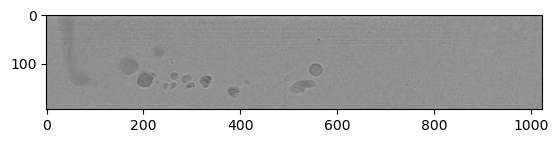

In [3]:
image = frame_generator(frames, 160, background = 19, cropv = (105, 300), croph = (None, None), takelog = True)

# convert numpy array to grayscale image
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

# convert image to RGB format
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# show image
plt.imshow(image, cmap='gray')
# plt.colorbar()

Import the SAM model and send it to the GPU

In [4]:
from segment_anything import build_sam, SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
checkpoint = "./model/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to("cuda")

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

SAM segments based on a prompt which can be a point. To segment everything in a frame, we prompt with a grid of points across the whole frame. The default build_point_grid() function only generates n * n grids, which become very distorted for high aspect ratio frames. Here we define a new function that generates an n * m grid. Choose values of n and m that are consistent with frame size and desired point density; the points are defined fractionally.

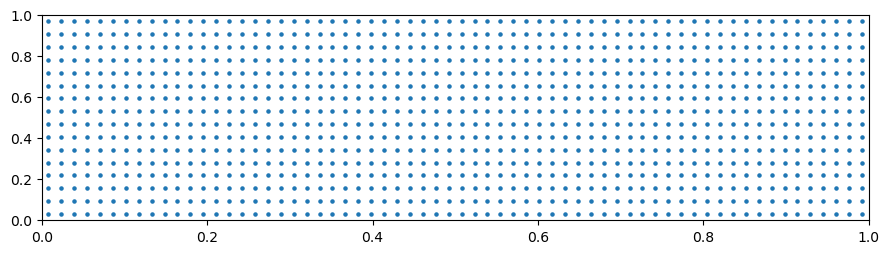

In [117]:
from typing import List

# Use evenly spaced points for a non-square image
def build_point_grid(n_x: int, n_y: int) -> np.ndarray:
    x_offset = 1 / (2 * n_x)
    y_offset = 1 / (2 * n_y)
    
    x_points_one_side = np.linspace(x_offset, 1 - x_offset, n_x)
    y_points_one_side = np.linspace(y_offset, 1 - y_offset, n_y)

    x_points = np.tile(x_points_one_side[None, :], (n_y, 1))
    y_points = np.tile(y_points_one_side[:, None], (1, n_x))

    points = np.stack([x_points, y_points], axis=-1).reshape(-1, 2)
    return points

# point_grid = build_point_grid(64, 16)
x = 64
y = 16
points = build_point_grid(x, y)

# Plot the point grid
plt.figure(figsize=(x/6, y/6))
plt.scatter(points[:, 0], points[:, 1], s=5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

def build_all_layer_point_grids(n_x: int, n_y: int, n_layers: int, scale_per_layer: int) -> List[np.ndarray]:
    """Generates point grids for all crop layers."""
    points_by_layer = []
    for i in range(n_layers + 1):
        n_x_i = int(n_x / (scale_per_layer ** i))
        n_y_i = int(n_y / (scale_per_layer ** i))
        points_by_layer.append(build_point_grid(n_x_i, n_y_i))
    return points_by_layer

crop_n_layers = 0
crop_n_points_downscale_factor = 1
points_by_layer = build_all_layer_point_grids(64, 16, crop_n_layers, crop_n_points_downscale_factor)

Load the model with the relevant point grid

In [118]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=None,
    point_grids=points_by_layer,
    points_per_batch=64, # Max 64 on 8 GB GPU with 32 points per side
    pred_iou_thresh=0.88,
    stability_score_thresh=0.92,
    # crop_n_layers=1,
    # crop_n_points_downscale_factor=2,
    # min_mask_region_area=100,  # Requires open-cv to run post-processing
)

Check cropping on image

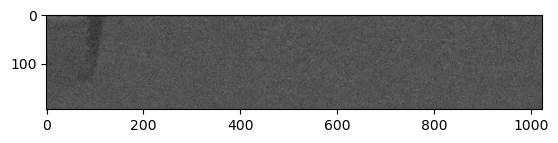

In [119]:
image = frame_generator_opencv(frames, 37, cropv=(105,300))
plt.imshow(image)

Test segmentation on a single frame. The output is a list of dictionaries, each containing a segmentation mask and its properties.

In [121]:
masks = mask_generator_2.generate(image)
areas = [d['area'] for d in masks]
print(areas)

[194461, 14928, 4031]


In [122]:
print(len(masks))
print(masks[0].keys())

3
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


The background is segmented as a large region, so we can remove it by filtering on area.

In [123]:
max_area = 10000
masks_trunc = [d for d in masks if d['area'] < max_area]

Show the segmentation regions

(-0.5, 1023.5, 194.5, -0.5)

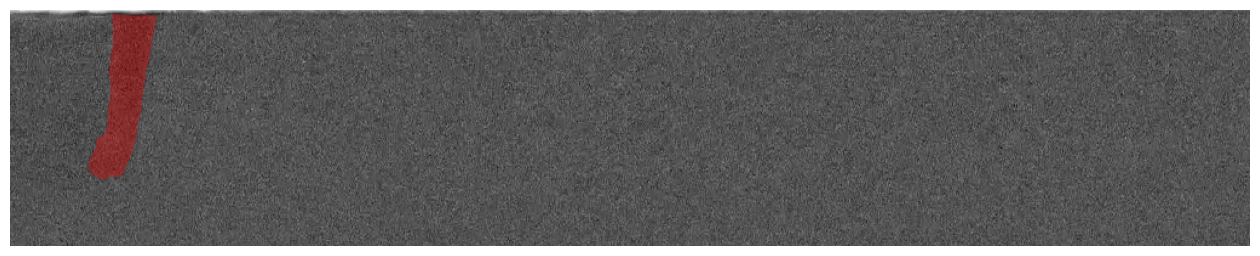

In [124]:
plt.figure(figsize=(16,4))
plt.imshow(image)
color = [1, 0, 0]  # Red
show_anns(masks_trunc, color)
plt.axis('off')
# plt.savefig('frame.png', bbox_inches='tight', pad_inches=0)
# plt.show()

Make a video. For application, we'd output the segmentation masks as a dataset to use to get insights.

In [125]:
# iterate through the indices of frames (skip first 20 frames)

for i in tqdm(range(20, len(frames), 1)):
    image = frame_generator_opencv(frames, i)
    masks = mask_generator_2.generate(image)
    # max_area = max(masks, key=lambda x: x['area'])['area']
    max_area = 8000
    masks_trunc = [d for d in masks if d['area'] < max_area]
    plt.figure(figsize=(16,4))
    plt.imshow(image)
    color = [1, 0, 0]  # Red
    show_anns(masks_trunc, color)
    plt.axis('off')
    # if frames does not exist, make frames
    if not os.path.exists('./frames'):
        os.makedirs('./frames')
    plt.savefig(f'./frames/frame{i}.png', bbox_inches='tight', pad_inches=0)
    # plt.show()
    # don't show figure
    plt.close()

make_video('frames/', 'output_video2.mp4', fps=30)

100%|██████████| 180/180 [19:25<00:00,  6.48s/it]
